# Secure aggregation

## Local model

 - Clients and a server
 - Client: holds sensitive data
 - Server: potentially malicious, collects and analyses the sensitive data

## Local DP

> Client: applies DP before sending the data to the server

Problem:
 - the noise is too much

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The following function appies the Laplace mechanism to a data.

In [2]:
def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

We compute the average of the ages two different way. 
 - The first method adds the Laplacian noise to sum of ages, and divides it by the number of people in the dataset with the Laplacian noise. (globa DP) 
 - The second method adds noise to each age and then sums them. (local DP)

We can see that the first result is quite accurate, why the second one is quite inaccurate. 

In [3]:
adult = pd.read_csv("data.csv")
print(adult['Age'].mean())
laplace_mech(adult['Age'].sum(), 100, 1) / laplace_mech(adult['Age'].shape[0], 1, 1)

41.02


41.01048699231661

In [4]:
noisy_age = np.array([x + np.random.laplace(loc=0, scale=100 / 1) for x in adult['Age']])
noisy_age.mean()

40.501968230547476

## Motivation

 - Collect data from clients without violate their privacy.
 - Clients can't send thier plain data:
    - Add noise - local DP
    - Add masks that cancel out when app up - Secure aggregate
    - Hide the identity of the client - Secure shuffle

## Secure Aggregation goals

 - Two client, Alice and Bob, and a server
 - Private informations: Alice $a \in \mathbb{Z}$, Bob: $b\in \mathbb{Z}$.
 - Goal:
    1. server computes $a + b$
    2. server doesn't learn anything from $a$, and $b$ (unless their sum)

## Secure Aggregation algorithm

Setup: Suppose Alice and Bob has a common random $r$ (mask), that only two of them knows.

> 1. Alice computes $a' = a + r$, and sends $a'$ to the server.
> 2. Bob computes $b' = b - r$, and sends $b'$ to the server.
> 3. Server computes $s = a' + b'$.

## Analyses

 - Correctness: $s = a' + b' = a + r + b -r = a +  b$.
 - Secrecy: Server only learns $a + r$ and $b - r$. As $r$ is random, it does not reveal any information from $a$ and $b$.

## Problems:

 1. How to do the setup?
 2. How to achieve DP?
 3. How to generalize it to more than two clients.

## How to do the setup?:

 - Use Diffie-Hellman key exchange between Alice and Bob to agree on a common seed.
 - Once they have a common seed, they can generate more using secure PRNG.
 - If no channel between Alice and Bob: do the DH through the server. 

## How to achieve DP?

 - The sum $a + b$ might be sensitive.
 - Alice adds noise to her data before sending to the server ($a' = a + r + s$, where $s$ is the noise).
 - Bob sends $b'$ without adding noise.
 - $s = a' + b' = a + b + s$, so the result of server is noisy. 

## How to generalize it to more than two clients.

 - All pairs of clients have a shared random value.
 - One pair member adds and the other subtracts the randomness from its data.
 - When the server adds up the data, the randomness cancels out.

## Secure Aggregation algorithm

Setup: 
 - That clients are index from 1 to $n$: $C_1,\dots,C_n$.
 - The secret information of $C_i$ is $x_i$.
 - Every pair of clients has a shared randomness (mask), that is $r_{ij} = r_{ji}$ for client $C_i$ and $C_j$.

> 1. Client $C_i$ computes $y_i = x_i + \sum_{i < j} r_{ij} - \sum_{i > j} r_{ij}$ and sends $y_i$ to the server.
> 2. Server computes $s = \sum y_i$.

## Analyses:

Correctness:
 - The shared masks cancel out $s = \sum y_i = \sum_{i} \left(x_i + \sum_{j <i} r_{ij} - \sum_{j >i} r_{ij}\right) = \sum_{i} x_i + \sum_{i < j} r_{i,j} - \sum_{i > j} r_{i,j} = \sum_{i} x_i$

Security:
 - Server only sees $y_i$. The server can't compute $x_i$ without knowing the masks.

Differentail Privacy:
 - The algorithm doesn't provide DP. If we want DP as well, one client should add a noise to it's value before sending to the server.

## Colluding adversary

 - It is possible that the server and some clients collude to learn the private information of other clients.
 - To compute the private information of $C_i$, the colluders need $r_{ij}$ for all $j$.
 - The protocol is secure it there is at least two non-colluding clients.

DP:
 - If the client who add noise collude with the server, the server can compute the sum without noise.

## Dropping clients

 - What if client $C_i$ fails to send it's data to the server?
 - The shared masks of $C_i$ can't be canceled out.
 - The server can't compute the sum even without the data of client $C_i$: $\sum_{j \neq i} x_j \neq \sum_{j \neq i} y_j$ 

## How to deal with dropping clients?

 - Use the algorithm only if clients won't drop.
   - Hospitals
 - Restore the dropped client's data
   - Secret sharing
 - The clients generate shared masks in only small groups.
   - If client drops => ignore only its group
   - Dropping probability should be low. 

# Secure Shuffling


## Secure Shuffling


 - Clients: data holder
 - Analyser: potentially malicious, analyses the data
 - Shuffler: collects the data from the clients, then send it to the analyser

## Secure Shuffling

 - Encoding: the client encodes the data
 - Shuffling: the shuffler anonyimze, batches and shuffles the data
 - Analysing: the analyser analyses the data

## Secure shuffle for 1 bit sum

 1. Encoding - randomized response
 2. Shuffling
 3. Analysing

## Encoding step (local randomizer)

Algorithm $R_\lambda$ 
> - Input: $x \in \{0,1\}$, parameters $n\in \mathbb{N},\lambda \in (0,n)$.
> - Output: $y \in \{0,1\}$

> 1. Let $b \leftarrow Ber(\lambda/n)$ ($ \leftarrow Ber(x)$ denotes sampling from the Bernoulli distribution with parameter $x$).
> 2. If $b = 0$: Return $x$
> 3. Else ($b= 1$) return $Ber(1/2)$

## Analyze step

> Input: $(y_1,\dots,y_n) \in \{0,1\}^n$, parameters $n\in \mathbb{N},\lambda \in (0,n)$.
> Output: $z\in [0,n]$
>
> Return $z = \frac{n}{n - \lambda}\left(\sum_{i=1}^n y_i - \frac{\lambda}{2} \right)$

## Analyze the algorithm

 - If there is no shuffling, then its a randomized response algorthm.
 - With some $\lambda$, it is $(\varepsilon,\delta)$-DP for arbitrary shuffler.

In [5]:
p, n = 0.7, 10000
value_bit = np.random.binomial(1, p, n)
value_bit.sum()

6968

In [6]:
def local_randomizer(x, n, lamb):
    b = np.random.binomial(1, lamb/n, 1)
    if b == 0:
        return x
    else:
        return np.random.binomial(1, .5, 1)[0]

In [7]:
def analyzing(y, n, lamb):
    return (n/(n-lamb)) * (y.sum() - lamb/2)

In [8]:
lamb = 825
randomized_value = np.asarray([local_randomizer(x, n, lamb) for x in value_bit])
analyzing(randomized_value, n, lamb)                        

6920.435967302453

## Secure shuffle for sum

 - We compute the sum of number in $[0,1]$.
 - Idea:
   - Encode every number into a binary vector of length $r$.
   - Randomize every bit of the vector with the local randomizer.
   - Adjust the error.
 - With some $\lambda$ and $r$, it is $(\varepsilon,\delta)$-DP for arbitrary shuffler.

## Encoding step 1 

The algorithm $E_r$:
 > - Input: $x \in [0,1]$, parameters $r\in \mathbb{N}$.
 > - Output: $(b_1,\dots,b_r) \in \{0,1\}^r$.

 > 1. Let $\mu = \lceil xr \rceil$ and $p = xr - \mu + 1$
 > 2. For $j = 1,\dots,r$:
 >    - if $j < \mu$: $b_j = 1$.
 >    - if $j = \mu$: $b_j = Ber(p)$.
 >    - if $j > \mu$: $b_j = 0$.

The expected value $\mathbb{E}(\frac{1}{r}\sum_{i=1}^r b_i )= x$

## Encoding step 2 (Local randomizer)

> - Input: $x \in [0,1]$, parameters $n,r\in \mathbb{N},\lambda \in (0,n)$.
> - Output: $(y_1,\dots,y_r) \in \{0,1\}^r$.

> 1. Compute $(b_1,\dots,b_r) = E_r(x)$.
> 2. Return $(y_1,\dots,y_r) = (R_\lambda(b_1),\dots,R_\lambda(b_r))$.

The encoder runs the local randomizer on every encoded bit.

## Analyzer
    
 > - Input: $(y_1,\dots,y_n) \in \{0,1\}^{nr}$, parameters $n,r\in \mathbb{N},\lambda \in (0,n)$.
 > - Output: $z\in [0,n]$

 > 1. Return $z = \frac{1}{r}\frac{n}{n-\lambda} \left(\left(\sum_j\sum_{i,j} y_{i,j}\right) - \frac{\lambda r}{2} \right)$


In [9]:
n = 10000
value_rac = np.random.rand(n, 1)
value_rac.sum()

4967.714601263825

In [10]:
def encode(x, r):
    mu = np.ceil(x * r)
    p = x * r - mu + 1
    b = []
    for j in range(1,r+1):
        if j < mu:
            b.append(1)
        elif j == mu:
            b.append(np.random.binomial(1, p, 1)[0])
        else: 
            b.append(0)
    return np.asarray(b)

In [11]:
def local_vector_randomizer(x, n, lamb):
    return np.asarray([local_randomizer(b, n, lamb) for b in x])

In [12]:
def analyzer_rac(y, n, r, lamb):
    return (1/r) * (n / (n - lamb)) * (y.sum() - lamb * r / 2)

In [13]:
lamb, r = 600, 30 
encoded_value_rac = [encode(x, r) for x in value_rac]
randomized_value_rac = np.asarray([local_vector_randomizer(x, n, lamb) for x in encoded_value_rac])
print(analyzer_rac(randomized_value_rac, n, r, lamb))

4963.404255319148


## How to use the shuffler in the algorithm

 - If the shuffler and analyser collude, there is no more privacy guarantee.
 - If there is no collusion:
    1. The client encrypts the data with the analysers public key.
    2. The shuffler collects the data from the client, shuffles it, then sends it to the analyser.
    3. The analyser decrypt the data

## Privacy

 - Shuffler: The shuffler sees the owner of the encrypted data, put can't read its content.
 - Analyst: Can encrypt the data, but doesn't know who it belongs to. 

## Shuffling techniques

Goal:
 - Collect data of clients.
 - Use more advanced techniques to shuffle

## Mix-nets

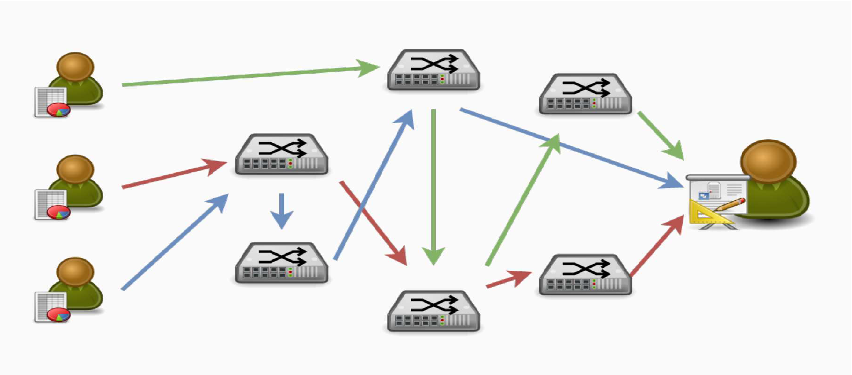

Advantages:
 - Lightweight (millions of msg)
 - Secure vs $k-1$ malicious node per path
 - Can use Tor

Disadvanteges:
 - Traffic-analys attacks
 - No correctness

## Verifiable shufflers

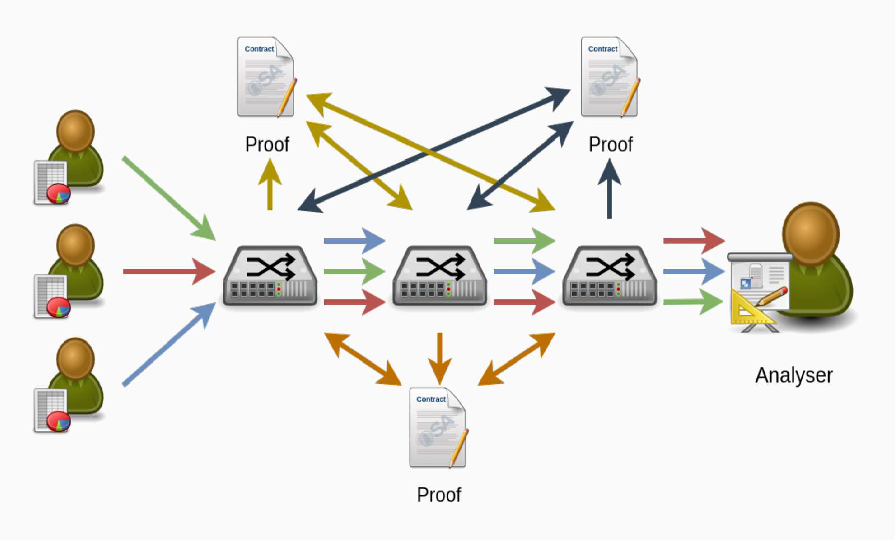

Advantages:
 - Secure vs $k-1$ malicious servers
 - Correctness
 - Auditable results

Disadvanteges:
 - Scaling limited to thousand of messages
 - Trusted setup

## DC-nets

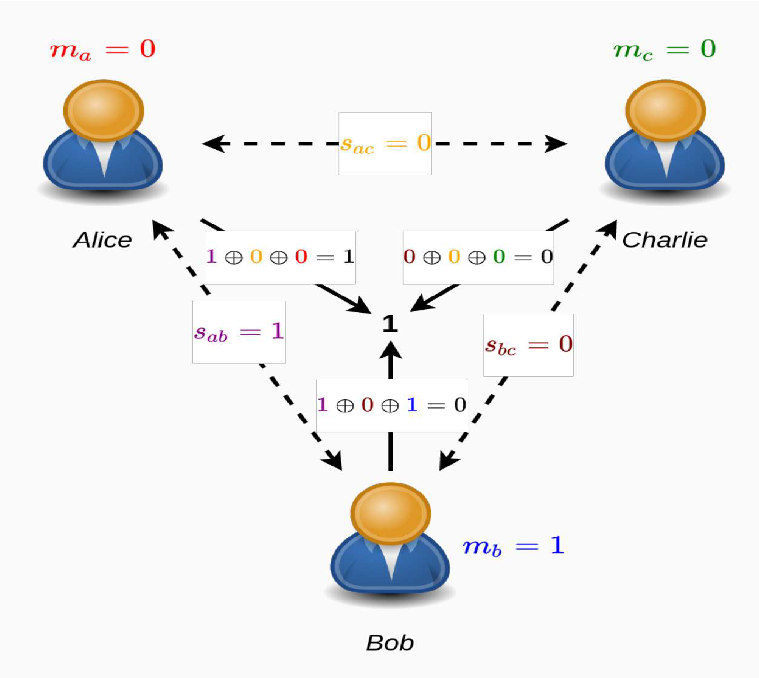

## MPC-based shufflers

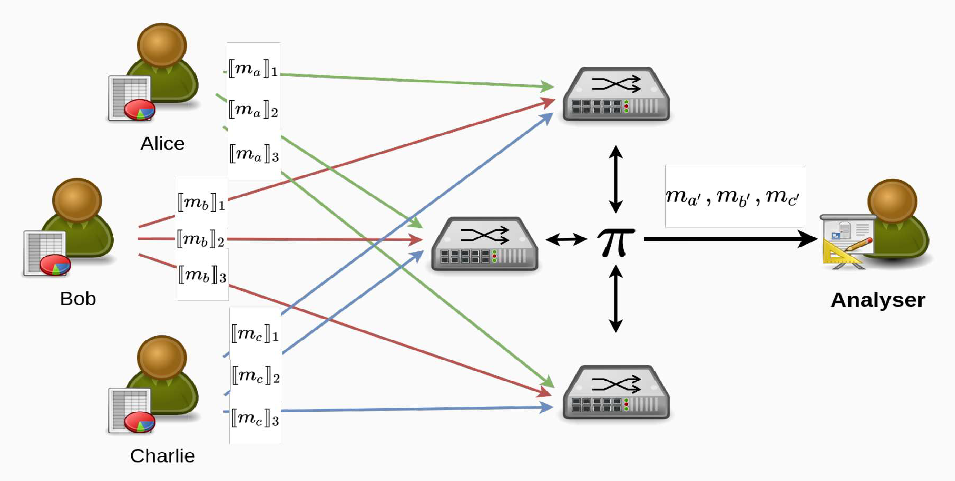

Advantages:
 - Can achieve the highest securitiy guarantees.
 - Scalable (up to a 1M msg)

Disadvantages:
 - Relatively large communication costs.
 - Secure vs. a proportion of malicious servers (e.g. < 1/3)

## Context 1:

A group of hospitals wants to deploy a privacy-preserving surveying system. 
The data owners (i.e. survey participants) answer the surveys on their web
browser and submit their answers through the shuffer.

Shuffler choice: Verifiable Shuffler- Scalability is not a problem (unlikely to have millions of submissions)
- Data owners can quickly submit and disconnect
-  Auditability is a nice pls.

## Context 2:

An open-source application wants to train an on-device recommenatione 
system. Several dozens of non-profit organizations agree to deploy shuffling
servers. Each user has some data on their local device.

Shuffler choice: Mix-nets - Can scale up to millions of data owners.
 - No explicit correctness or auditability requirement
 - Strong threat model because NPOs are less trustworthy than hospitals.

## Context 3:

A dozen of hospitals wants to collaborate and uses their medical data to trani 
a complex Deep Learning model to assist the practitioners. Each hospital tc s
at the same time as a shuffling server and a data owner.

Shuffler choice: MPC-based shuffler - Number of messages is very small ⇒ no cost issue
 - Correctness is important due to the sensitivity of the use case
 - A weaker threat model is acceptable since hospitals have a reputation issue and should be honest (except if compromise).